In [7]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

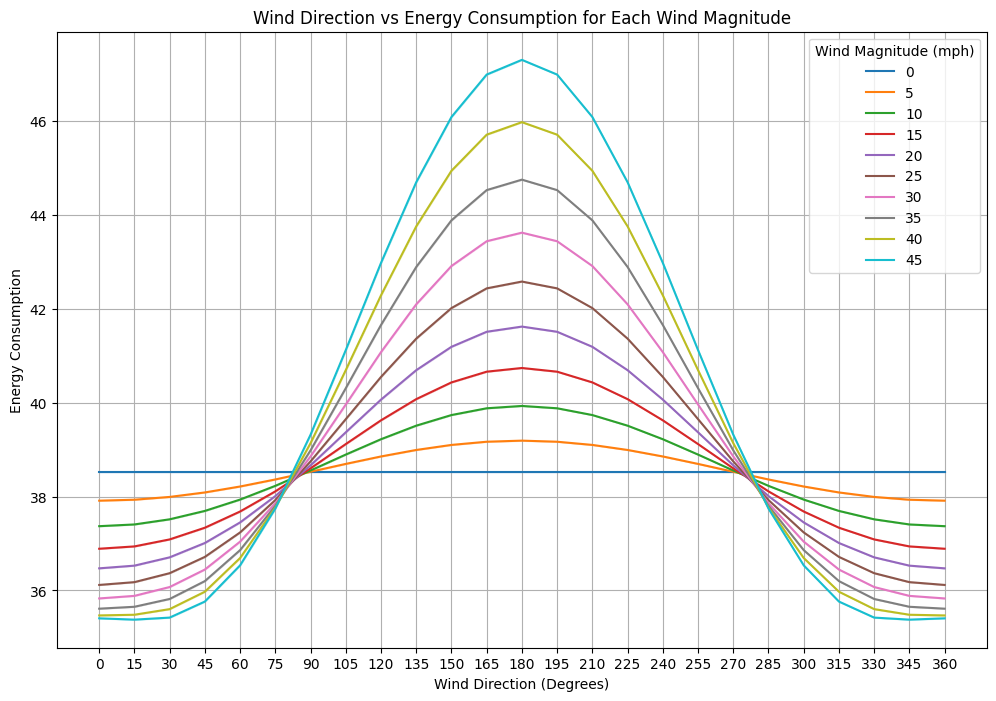

In [9]:
# Reconnect to the SQLite database
conn = sqlite3.connect('energy_and_flight_time.sqlite')

# Query to select the relevant columns
query = """
SELECT energy_consumption, wind_direction_degrees, wind_magnitude_mph
FROM flight_metrics
"""

# Loading the data into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Plotting for WARNER_HHR
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='wind_direction_degrees', y='energy_consumption', hue='wind_magnitude_mph', palette='tab10')
plt.title('Wind Direction vs Energy Consumption for Each Wind Magnitude')
plt.xlabel('Wind Direction (Degrees)')
plt.ylabel('Energy Consumption')
plt.xticks(list(range(0, 365, 15)))
plt.legend(title='Wind Magnitude (mph)')
plt.grid(True)
plt.show()


In [14]:
file_path = 'updated_sfo_sjc_route_60_miles.csv'
data = pd.read_csv(file_path)

# Remove rows with NaN values
data_cleaned = data.dropna()

# Summing energy consumption values for each flight phase for each flight direction
grouped_data = data_cleaned.groupby(['flight_direction', 'phase'])['energy_consumption'].sum().reset_index()

# Display the grouped data to verify before plotting
grouped_data.head()

,flight_direction,phase,energy_consumption
0,SFO_SJC,CLIMB,4.564184
1,SFO_SJC,CLIMB TRANSITION,3.894426
2,SFO_SJC,CRUISE,19.761748
3,SFO_SJC,DESCENT,2.366142
4,SFO_SJC,DESCENT TRANSITION,3.134298


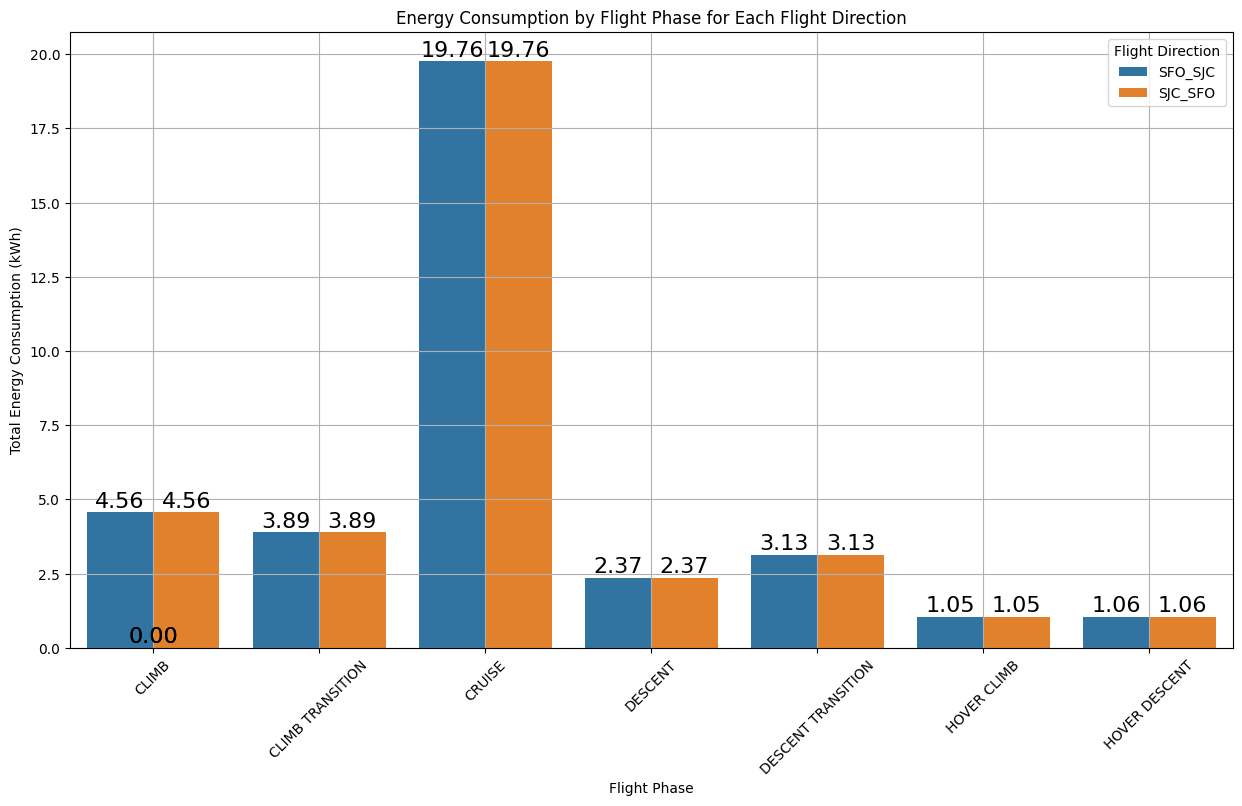

In [15]:
# Plotting all flight directions in the same bar plot with a legend to identify them
plt.figure(figsize=(15, 8))
sns.barplot(x='phase', y='energy_consumption', hue='flight_direction', data=grouped_data, palette='tab10')

# Adding values on top of the bars
for bar in plt.gca().patches:
    plt.gca().annotate(format(bar.get_height(), '.2f'), 
                       (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                       ha='center', va='center', 
                       size=16, xytext=(0, 8), 
                       textcoords='offset points')

plt.title('Energy Consumption by Flight Phase for Each Flight Direction')
plt.xlabel('Flight Phase')
plt.ylabel('Total Energy Consumption (kWh)')
plt.legend(title='Flight Direction')
plt.xticks(rotation=45)
plt.grid()
plt.show()


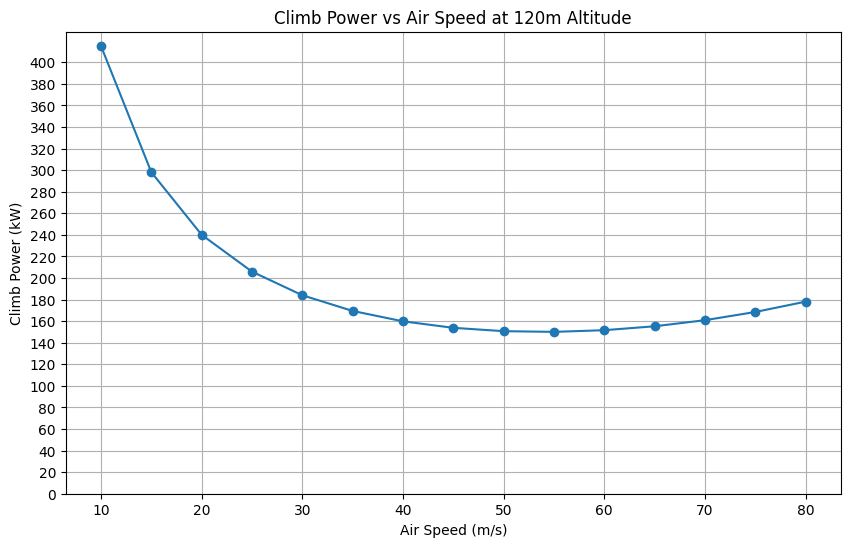

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Constants and aircraft parameters
G_CONSTANT = 9.80665  # m/s^2

aircraft_params = {
    "mtom": 2182,  # Maximum take-off mass in kg
    "wing_area": 13,  # Wing area in m^2
    "disk_load": 45.9,  # Disk load in kg/m^2
    "f": 1.03,
    "FoM": 0.8,
    "cd_0": 0.015,  # Zero lift drag coefficient
    "cl_max": 1.5,  # Maximum lift coefficient
    "ld_max": 18,  # Maximum lift-to-drag ratio
    "eta_hover": 0.85,  # Hover efficiency
    "eta_climb": 0.85,
    "eta_descend": 0.85,
    "eta_cruise": 0.9,
    "atmosphere_condition": "good",
    "climb_phase_vertical_velocity": 2.5  # m/s
}

# Functions for calculations
def temperature(altitude: float) -> float:
    return 288.16 - 6.5 * 10**-3 * altitude

def lift_induced_drag_coef(cd_0: float, ld_max: float) -> float:
    return 1 / (4 * cd_0 * ld_max**2)

def weight(mass):
    return mass * G_CONSTANT

def atmosphere_params(condition: str):
    if condition == 'good':
        tgl = 288.15 # Ground temperature [K]
        dgl = 1.225 # Ground density [kg/m^3]
    elif condition == 'bad':
        tgl = 300 # Ground temperature [K]
        dgl = 0.974 # Ground density [kg/m^3]
    return tgl, dgl

def rho(altitude: float, atmosphere_condition: str='good'):
    tgl, dgl = atmosphere_params(atmosphere_condition)
    return dgl * (temperature(altitude)/tgl)**((G_CONSTANT/(287*6.5*10**-3))-1)

def climb_descent_power(aircraft_params, tom, altitude, vertical_velocity, air_speed, k_multiplier=1, direction='down'):
    if direction == 'down':
        vertical_velocity = -vertical_velocity
    elif direction != 'up':
        raise ValueError('direction must be either "up" or "down"')
    density = rho(altitude=altitude, atmosphere_condition=aircraft_params['atmosphere_condition'])
    term1 = weight(tom) * vertical_velocity
    term2 = 1/2 * density * aircraft_params['wing_area'] * aircraft_params['cd_0'] * air_speed**3
    term3 = k_multiplier * lift_induced_drag_coef(cd_0=aircraft_params['cd_0'], ld_max=aircraft_params['ld_max']) \
            * weight(tom)**2 / (1/2 * density * aircraft_params['wing_area'] * air_speed)
    return (term1 + term2 + term3) / aircraft_params['eta_hover']

# Calculating climb power for different air speeds at cruise altitude
air_speed_values = np.arange(10, 81, 5)  # Air speeds from 10 to 80 m/s
climb_powers = [climb_descent_power(aircraft_params=aircraft_params, 
                                    tom=aircraft_params['mtom'], 
                                    altitude=120, 
                                    vertical_velocity=aircraft_params['climb_phase_vertical_velocity'], 
                                    air_speed=v,
                                    direction='up')/1000 for v in air_speed_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(air_speed_values, climb_powers, marker='o')
plt.title('Climb Power vs Air Speed at 120m Altitude')
plt.xlabel('Air Speed (m/s)')
plt.ylabel('Climb Power (kW)')
plt.grid(True)
ymax = np.max(climb_powers)+1
plt.yticks(np.arange(0, ymax, 20))
plt.show()


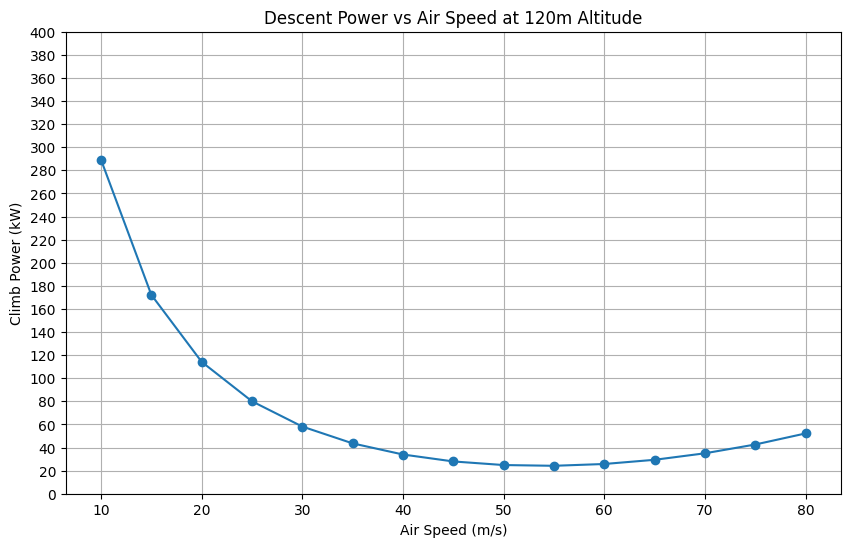

In [11]:
# Calculating climb power for different air speeds at cruise altitude
air_speed_values = np.arange(10, 81, 5)  # Air speeds from 10 to 80 m/s
climb_powers = [climb_descent_power(aircraft_params=aircraft_params, 
                                    tom=aircraft_params['mtom'], 
                                    altitude=120, 
                                    vertical_velocity=aircraft_params['climb_phase_vertical_velocity'], 
                                    air_speed=v,
                                    direction='down')/1000 for v in air_speed_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(air_speed_values, climb_powers, marker='o')
plt.title('Descent Power vs Air Speed at 120m Altitude')
plt.xlabel('Air Speed (m/s)')
plt.ylabel('Climb Power (kW)')
plt.grid(True)
plt.yticks(np.arange(0, ymax, 20))
plt.show()